In [90]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords

import matplotlib.pyplot as plt


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nmaligazhdarova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Analyzing datasets

- DiverseVul dataset: https://github.com/wagner-group/diversevul
- PrimeVul dataset: https://github.com/DLVulDet/PrimeVul
- SVEN dataset: https://github.com/eth-sri/sven

In [6]:
df_div_prime_sven = pd.read_csv("initial_datasets/diverse_primevul_sven.csv")

df_diverse = pd.read_csv("initial_datasets/filtered_diverse.csv")

df_prime = pd.read_csv("initial_datasets/filtered_primevul_train.csv")
df_prime_test = pd.read_csv("initial_datasets/filtered_primevul_test.csv")

df_sven_train = pd.read_csv("initial_datasets/sven_train.csv")
df_sven_valid = pd.read_csv("initial_datasets/sven_valid.csv")

In [11]:
print("Final Diverse + PrimeVul + Sven datasets: ", df_div_prime_sven.shape)
print("DiverseVul: ", df_diverse.shape)
print("PrimeVul: ", df_prime.shape, df_prime_test.shape)
print("SVEN: ", df_sven_train.shape, df_sven_valid.shape)

Final Diverse + PrimeVul + Sven datasets:  (849, 8)
DiverseVul:  (103, 8)
PrimeVul:  (407, 8) (135, 8)
SVEN:  (184, 8) (20, 8)


In [12]:
print("Final dataset True and False values: ")
print(len(df_div_prime_sven[df_div_prime_sven['target']==1]))
print(len(df_div_prime_sven[df_div_prime_sven['target']==0]))

Final dataset True and False values: 
257
592


#### Undersampling the Final dataset

In [15]:
def undersample(df, target_col):
    class_counts = df[target_col].value_counts()
    
    minority_class_label = class_counts.idxmin()
    
    minority_class_count = class_counts[minority_class_label]
    
    majority_class_count = class_counts.drop(minority_class_label).max()
    
    ratio = minority_class_count / majority_class_count
    
    majority_class_sampled = df[df[target_col] != minority_class_label].sample(frac=ratio, random_state=42)
    
    undersampled_df = pd.concat([majority_class_sampled, df[df[target_col] == minority_class_label]])
    
    return undersampled_df

In [16]:
# def undersample_and_save(df, target_col, output_file):
#     undersampled_df = undersample(df, target_col)    
#     undersampled_df.to_csv(output_file, index=False)

# undersample_and_save(df_div_prime_sven, 'target', "final_datasets/under_diverse_primevul_sven.csv")

#### Analyzing the Final dataset

In [17]:
df_un_div_prime_sven = pd.read_csv("final_datasets/under_diverse_primevul_sven.csv")

print("Final undersampled dataset True and False values: ")
print(len(df_un_div_prime_sven[df_un_div_prime_sven['target']==1]))
print(len(df_un_div_prime_sven[df_un_div_prime_sven['target']==0]))

Final undersampled dataset True and False values: 
257
257


In [19]:
train_size_under_dps = int(0.7 * len(df_un_div_prime_sven))
df_shuffled = df_un_div_prime_sven.sample(frac=1)

train_data_under = df_shuffled.iloc[:train_size_under_dps]
test_data_under = df_shuffled.iloc[train_size_under_dps:]

In [20]:
train_data_under.head()

,func,target,cwe,project,commit_id,hash,size,message
475,"def followFriends(self,userid,friendid):\n...",1,cwe-089,NaN,NaN,NaN,NaN,NaN
408,"def add_input(self, data):\n connec...",1,cwe-089,NaN,NaN,NaN,NaN,NaN
91,bool JOIN::get_best_combination()\n{\n uint t...,0,['CWE-89'],server,5ba77222e9fe7af8ff403816b5338b18b342053c,83630079315190795246411860210495828029,177.0,MDEV-21028 Server crashes in Query_arena::set_...
183,"add_keyuse(DYNAMIC_ARRAY *keyuse_array, KEY_FI...",0,['CWE-89'],server,5ba77222e9fe7af8ff403816b5338b18b342053c,110507238188904002829600511945629512113,27.0,MDEV-21028 Server crashes in Query_arena::set_...
189,\t\tvoid CWebServer::ReloadCustomSwitchIcons()...,0,CWE-89,domoticz,ee70db46f81afa582c96b887b73bcd2a86feda00,285520992365248360026663711530896169457,NaN,NaN


In [22]:
print("Train dataset's True and False values: ")
print(len(train_data_under[train_data_under['target']==1]))
print(len(train_data_under[train_data_under['target']==0]))

Train dataset's True and False values: 
172
187


In [23]:
print("Test dataset's True and False values: ")
print(len(test_data_under[test_data_under['target']==1]))
print(len(test_data_under[test_data_under['target']==0]))

Test dataset's True and False values: 
85
70


#### Processing the Final dataset for SVC model

In [24]:
def scale_dataset(dataframe, oversample=False):
  X = dataframe['func']
  y = dataframe['target']

  vectorizer = CountVectorizer(min_df = 2, max_df = 0.8, stop_words = stopwords.words('english'))
  X = vectorizer.fit_transform(X.values.astype('U')).toarray()

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  # if oversample:
  #   ros = RandomOverSampler()
  #   X, y = ros.fit_resample(X, y)

  dataframe = np.hstack((X, np.reshape(y, (-1, 1))))

  return dataframe, X, y

In [25]:
dataframe, X, y = scale_dataset(df_un_div_prime_sven, oversample=True)

In [26]:
print(dataframe.shape)

(514, 3067)


In [37]:
print("Final dataset after the vectorization: \n\n", dataframe[0:5])

Final dataset after the vectorization: 

 [[-0.05356562 -0.0625     -0.08398388 ... -0.0625     -0.0625
   0.        ]
 [-0.05356562 -0.0625     -0.08398388 ... -0.0625     -0.0625
   0.        ]
 [-0.05356562 -0.0625     -0.08398388 ... -0.0625     -0.0625
   0.        ]
 [-0.05356562 -0.0625     -0.08398388 ... -0.0625     -0.0625
   0.        ]
 [-0.05356562 -0.0625     -0.08398388 ... -0.0625     -0.0625
   0.        ]]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(" Train dataset shape: ", X_train.shape, y_train.shape, "\n Test dataset shape: ", X_test.shape,  y_test.shape)

 Train dataset shape:  (359, 3066) (359,) 
 Test dataset shape:  (155, 3066) (155,)


## Statistics about the dataset

In [38]:
true_data = dataframe[dataframe[:, -1] == 1]
false_data = dataframe[dataframe[:, -1] == 0]

data = np.vstack((true_data, false_data))

true_labels = np.ones((true_data.shape[0],), dtype=int)
false_labels = np.zeros((false_data.shape[0],), dtype=int)
labels = np.concatenate((true_labels, false_labels))

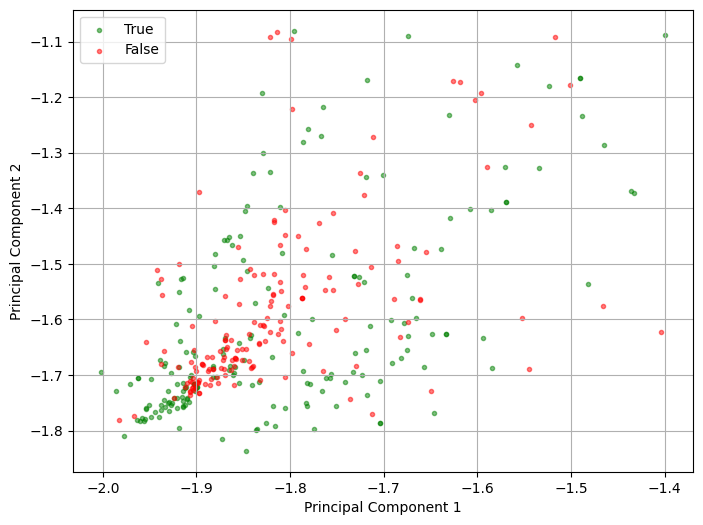

In [40]:
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data)

median_values = np.median(data_reduced, axis=0)
mad_values = np.median(np.abs(data_reduced - median_values), axis=0)

outlier_threshold = 3.0
outlier_mask = np.any(np.abs(data_reduced - median_values) > outlier_threshold * mad_values, axis=1)

filtered_data_reduced = data_reduced[~outlier_mask]
filtered_labels = labels[~outlier_mask]

x_values = filtered_data_reduced[:, 0]
y_values = filtered_data_reduced[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(x_values[filtered_labels == 1], y_values[filtered_labels == 1], c='green', marker='.', label='True', alpha=0.5)
plt.scatter(x_values[filtered_labels == 0], y_values[filtered_labels == 0], c='red', marker='.', label='False', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

## SVC model

### Hyper-tuning the parameters

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [49]:
svm = SVC()

param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': ['auto']},
  {'C': [1, 10, 100, 1000], 'gamma': ['auto'], 'kernel': ['rbf']},
 ]

grid = GridSearchCV(svm,param_grid)

In [50]:
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'gamma': ['auto']},
                         {'C': [1, 10, 100, 1000], 'gamma': ['auto'],
                          'kernel': ['rbf']}])

In [51]:
grid_svc = grid.predict(X_test)
accuracy_score(y_test,grid_svc)

0.9612903225806452

In [144]:
print(classification_report(y_test, grid_svc))

y_true = y_test
y_pred = grid_svc  

TN_SVC, FP_SVC, FN_SVC, TP_SVC = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        82
           1       0.97      0.95      0.96        73

    accuracy                           0.96       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.96      0.96      0.96       155



In [55]:
results_df = pd.DataFrame(grid.cv_results_)

results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")

save_output = results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

In [56]:
# save_output.to_csv("hyper_parameters_results.csv", index=False)

## GPT fine-tuning the model

In [149]:
import json
import jsonlines

from openai import OpenAI

In [150]:
df = pd.read_csv("final_datasets/under_diverse_primevul_sven.csv").sample(frac=1)
df.head()

,func,target,cwe,project,commit_id,hash,size,message
42,\t\tvoid CWebServer::Cmd_GetHardwareTypes(WebE...,0,CWE-89,domoticz,ee70db46f81afa582c96b887b73bcd2a86feda00,267720109913093530859379052733461853792,NaN,NaN
485,"@mod.route('/test', methods=['GET', 'POST'])\n...",1,cwe-089,NaN,NaN,NaN,NaN,NaN
238,bool subselect_union_engine::no_tables()\n{\n ...,0,['CWE-89'],server,3c209bfc040ddfc41ece8357d772547432353fd2,332371065322920254027750936800733766087,9.0,MDEV-25994: Crash with union of my_decimal typ...
483,"def process_ranks(self, scene, urls, recen...",1,cwe-089,NaN,NaN,NaN,NaN,NaN
369,"def fetch_data(self, session, id):\n ...",1,cwe-089,NaN,NaN,NaN,NaN,NaN


In [151]:
train, test = np.split(df.sample(frac=1), [int(0.7*len(df))])

/Users/nmaligazhdarova/Desktop/project/.venv copy/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [152]:
print(train.shape)
print(test.shape)

(359, 8)
(155, 8)


In [153]:
# Save train and test datasets in CSV file

# train.to_csv('final_datasets/tmp/train.csv', index=False)
# test.to_csv('final_datasets/tmp/test.csv', index=False)

#### Converting dataset to the acceptable GPT format

In [154]:
def convert_target_dataset(input, output):
    input = pd.read_csv(input)
    
    with open(output, 'w') as f:
        for index, row in input.iterrows():
            jsonl_data = {
                "messages": [
                    {"role": "system", "content": "You will be provided with a piece of C++ code, and your task is to define whether this code is vulnerable to SQL Injection. Provide answer: True or False"},
                    {"role": "user", "content": row['func']},
                    {"role": "assistant", "content": str(bool(row['target']))}
                ]
            }

            f.write(json.dumps(jsonl_data) + '\n') # 

In [155]:
# convert_target_dataset("final_datasets/tmp/train.csv", "final_datasets/train_dataset_for_GPT.jsonl")

In [156]:
def convert_test_dataset(input, output):
    with open(output, 'w') as output_file:
        input = pd.read_csv(input)
        
        for index, row in input.iterrows():
            prompt_message = {
                "role": "system",
                "content": "You will be provided with a piece of C++ code, and your task is to define whether this code is vulnerable to SQL Injection. Provide answer: True or False"
            }
            user_message = {
                "role": "user",
                "content": row['func']
            }
            # print(prompt_message)
            # print(user_message)
            
            input_output_pair = {
                "messages": [prompt_message, user_message, {"role": "assistant", "content": "assistant_response"}]
            }

            output_file.write(json.dumps(input_output_pair) + '\n')

In [157]:
# convert_test_dataset("final_datasets/tmp/test.csv", "final_datasets/test_dataset_for_GPT.jsonl")

#### Fine-tuning the model

In [158]:
client = OpenAI(api_key="--------------") # your API key

In [159]:
def step_1(file_path):
    with open(file_path, 'rb') as file:
        response = client.files.create(file=file, purpose='fine-tune')
        print(response)

In [160]:
def step_2(file_name):
    response = client.fine_tuning.jobs.create(
    training_file=file_name, 
    model="gpt-3.5-turbo-1106"
    )
    print(response)

In [161]:
def step_3(output_file_to_save, test_dataset, model_name):

    with open(output_file_to_save, 'w') as output_file:
        # Iterate over each code snippet in the test dataset
        test_dataset = pd.read_csv(test_dataset)
        
        for index, row in test_dataset.iterrows():
            # Create a prompt message
            prompt_message = {
                "role": "system",
                "content": "You will be provided with a piece of C++ code, and your task is to define whether this code is vulnerable to SQL Injection. Provide answer: True or False"
            }
            
            user_message = {
                "role": "user",
                "content": row['func']
            }
            # print(prompt_message)
            # print(user_message)

            completion = client.chat.completions.create(
                model=model_name,
                messages=[prompt_message, user_message]
            )
            
            # Extract the completion output
            assistant_response = completion.choices[0].message.content
            

            input_output_pair = {
                "messages": [prompt_message, user_message, {"role": "assistant", "content": assistant_response}]
            }

            output_file.write(json.dumps(input_output_pair) + '\n')

In [162]:
# step_1("dataset/train.jsonl")

In [163]:
# paste the final name from the Step 1

# step_2('file-8f4t77G2x0UdehFqExDsr2k2')

In [164]:
# paste the name of the model after Step 2

# step_3('final_datasets/final_results.jsonl', 'final_datasets/tmp/test.csv', 'ft:gpt-3.5-turbo-1106:-------------')

#### Analyze the results

In [165]:
def count_true_false(jsonl_file):
    false_count = 0
    true_count = 0

    with jsonlines.open(jsonl_file) as reader:

        for obj in reader:

            messages = obj.get("messages", [])
            for message in messages:
                if message.get("content") == 'False':
                    false_count += 1

                if message.get("content") == 'True':
                    true_count += 1


    print(" 'False' field:", false_count)
    print(" 'True' field:", true_count)

In [166]:
count_true_false('final_datasets/final_results.jsonl')

 'False' field: 85
 'True' field: 70


In [167]:
# actual True and False values
import csv

count_actual_values = []

test_df = 'final_datasets/tmp/test.csv'

with open(test_df, "r") as csvfile:
  reader = csv.reader(csvfile)
  next(reader, None)

  for row in reader:
    count_actual_values.append(int(row[1]))

In [168]:
len(count_actual_values)

155

In [169]:
count_values = []

json_file = 'final_datasets/final_results.jsonl'

with jsonlines.open(json_file) as reader:
    for obj in reader:
        messages = obj.get("messages", [])
        for message in messages:
            if message.get("role") == "assistant":
                # print(message.get("content"))

                if message.get("content") == 'False':
                    count_values.append(0)
                if message.get("content") == 'True':
                    count_values.append(1)

In [170]:
print(count_actual_values)

[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1]


In [171]:
print(count_values)

[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1]


In [176]:
y_true = count_actual_values
y_pred = count_values  

TN_LLM, FP_LLM, FN_LLM, TP_LLM = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

In [187]:
def calculate_results(TN, FP, FN, TP):
    ACC = (TP+TN)/(TP+FP+FN+TN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = 2 * (Precision * Recall) / (Precision + Recall)

    print("True negative: ", TN, "\nFalse positive: ", FP, "\nFalse negative: ", FN, "\nTrue positive", TP)
    print("")
    print("Accuracy: ", round(ACC, 4), "\nPrecision: ", round(Precision, 4), "\nRecall: ", round(Recall, 4), "\nF1: ", round(F1, 4))

## Final results

In [188]:
print("\n------------------ SVC model ------------------\n")
print(calculate_results(TN_SVC, FP_SVC, FN_SVC, TP_SVC))

print("\n------------------ LLM fine-tuned model ------------------\n")
print(calculate_results(TN_LLM, FP_LLM, FN_LLM, TP_LLM))


------------------ SVC model ------------------

True negative:  80 
False positive:  2 
False negative:  4 
True positive 69

Accuracy:  0.9613 
Precision:  0.9718 
Recall:  0.9452 
F1:  0.9583
None

------------------ LLM fine-tuned model ------------------

True negative:  82 
False positive:  0 
False negative:  3 
True positive 70

Accuracy:  0.9806 
Precision:  1.0 
Recall:  0.9589 
F1:  0.979
None
